In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from src.util import read_video_frames, display_image, draw_bounding_box, draw_3d_bounding_boxes, render_scene, get_character_placeholder
from src.operations2d import get_2d_bounding_boxes, bounding_boxes_to_image_chunks
from src.operations3d import get_3d_bounding_boxes, adjust_centers_by_chunk_rotation, get_box_meshes

In [5]:
video_path = "vids/office.mp4"
frame_index = 50

object_class = "cupboard"

Read out a single frame of the input video

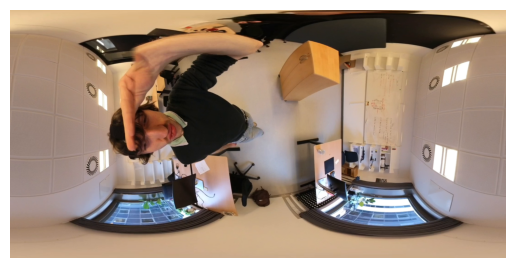

In [6]:
input_frame = read_video_frames(video_path)[frame_index]

display_image(input_frame)

Get 2d bounding boxes for objects of interest

In [7]:
bounding_boxes = get_2d_bounding_boxes(input_frame, object_class)
print(bounding_boxes)

final text_encoder_type: bert-base-uncased


[[0.6036693  0.24801159 0.12584625 0.24816552]]


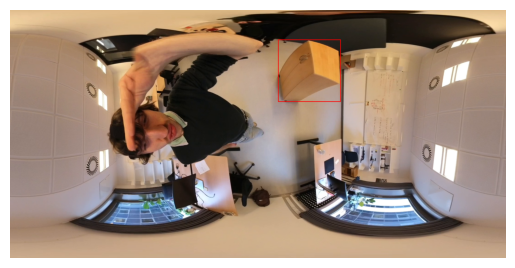

In [8]:
frame_with_boxes = input_frame.copy()
for box in bounding_boxes:
    frame_with_boxes = draw_bounding_box(frame_with_boxes, box)

display_image(frame_with_boxes)

Extract and undistort image chunks around objects

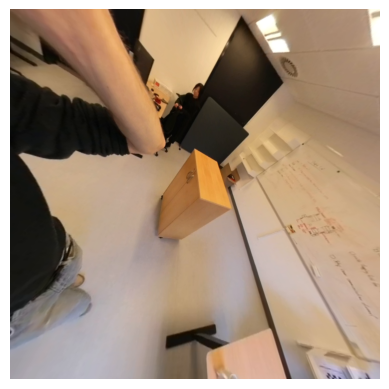

In [9]:
image_chunks = bounding_boxes_to_image_chunks(input_frame, bounding_boxes)
display_image(image_chunks[0].image)

Get 3d bounding boxes

In [10]:
bb_centers, bb_dimensions, bb_poses = get_3d_bounding_boxes(image_chunks[0], object_class)

[01/28 15:47:35 detectron2]: Rank of current process: 0. World size: 1
[01/28 15:47:36 detectron2]: Environment info:
-------------------------------  -------------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.8.20 (default, Oct  3 2024, 15:24:27) [GCC 11.2.0]
numpy                            1.24.4
detectron2                       0.6 @/home/max/miniconda3/envs/instruct360/lib/python3.8/site-packages/detectron2
Compiler                         GCC 13.3
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.4.1+cu121 @/home/max/miniconda3/envs/instruct360/lib/python3.8/site-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    No: torch.cuda.is_available() == False
Pillow                           10.4.0
torchvision                      0.19

Using cache found in /home/max/.cache/torch/hub/facebookresearch_dinov2_main


final text_encoder_type: bert-base-uncased
[01/28 15:47:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from checkpoints/ovmono3d_lift.pth ...
[01/28 15:47:39 fvcore.common.checkpoint]: [Checkpointer] Loading from checkpoints/ovmono3d_lift.pth ...
WARNING [01/28 15:47:39 fvcore.common.checkpoint]: Some model parameters or buffers are not found in the checkpoint:
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.attn.proj.{bias, weight}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.attn.qkv.{bias, weight}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.attn.{relative_position_bias_table, relative_position_index}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.mlp.fc1.{bias, weight}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.mlp.fc2.{bias, weight}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.norm1.{bias, weight}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.norm2.{bias, weight}


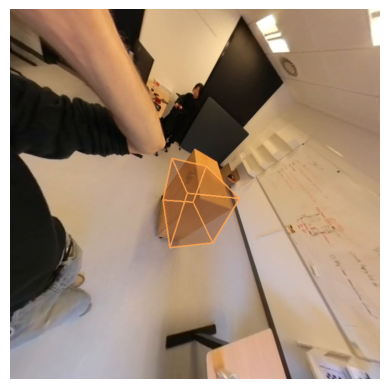

In [11]:
image_with_3d_boxes = draw_3d_bounding_boxes(image_chunks[0], bb_centers, bb_dimensions, bb_poses)
display_image(image_with_3d_boxes)

Get bounding box meshes in world space an render them

In [34]:
bb_centers_adjusted = adjust_centers_by_chunk_rotation(bb_centers, image_chunks[0])
bb_meshes = get_box_meshes((bb_centers_adjusted, bb_dimensions, bb_poses))
character_placeholder = get_character_placeholder()
render_scene(bb_meshes + [character_placeholder])